In [ ]:
!pip install pandas matplotlib sklearn

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

In [6]:
df = pd.read_csv(os.path.join('sample_data','train.csv'), error_bad_lines=False, engine="python")

<ipython-input-6-db67aad704bb>:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv(os.path.join('sample_data','train.csv'), error_bad_lines=False, engine="python")
Skipping line 48647: unexpected end of data


In [7]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


#Preprocessing the Data

In [8]:
from tensorflow.keras.layers import TextVectorization

In [9]:
df.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

In [10]:
X = df['comment_text']
y = df[df.columns[2:]].values

In [11]:
MAX_FEATURES = 20000

In [12]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')

In [13]:
vectorizer.adapt(X.values)

In [14]:
len(vectorizer.get_vocabulary())

20000

In [15]:
vectorizer("hello world")

<tf.Tensor: shape=(1800,), dtype=int64, numpy=array([294, 268,   0, ...,   0,   0,   0])>

In [16]:
vectorized_text = vectorizer(X.values)

In [17]:
vectorized_text

<tf.Tensor: shape=(48645, 1800), dtype=int64, numpy=
array([[ 683,   74,    2, ...,    0,    0,    0],
       [   1,   54, 2328, ...,    0,    0,    0],
       [ 492,  430,   72, ...,    0,    0,    0],
       ...,
       [ 376,    2,  135, ...,    0,    0,    0],
       [ 264, 1122,  850, ...,    0,    0,    0],
       [1255,   14,    3, ...,    0,    0,    0]])>

In [18]:
len(vectorized_text)

48645

In [19]:
#MCSHBAP - map, chache, shuffle, batch, prefetch  from_tensor_slices, list_file
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(len(vectorized_text))
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) # helps bottlenecks


In [20]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

#Create Model

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [22]:
model = Sequential()
# Create the embedding layer
model.add(Embedding(MAX_FEATURES+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer
model.add(Dense(6, activation='sigmoid'))

In [23]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [35]:
history = model.fit(train, epochs=2, validation_data=val)

Epoch 1/2
2128/2128 [==============================] - 229s 108ms/step - loss: 0.0480 - val_loss: 0.0414
Epoch 2/2
2128/2128 [==============================] - 252s 118ms/step - loss: 0.0437 - val_loss: 0.0394


In [36]:
import matplotlib.pyplot as plt

<Figure size 800x500 with 0 Axes>

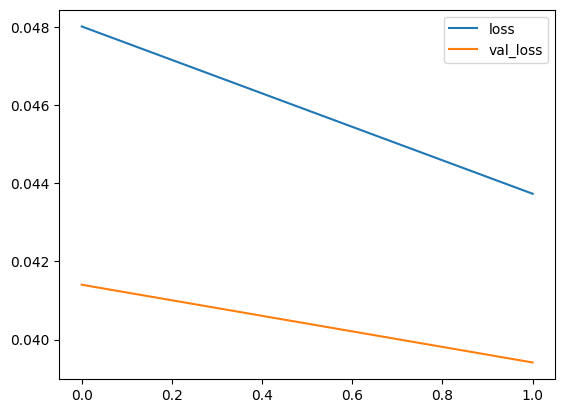

In [37]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

In [38]:
model.predict(np.expand_dims(vectorizer("You should just go die"), axis=0))

1/1 [==============================] - 0s 79ms/step


array([[0.9290858 , 0.03507315, 0.5863854 , 0.03461056, 0.51959807,
        0.08823365]], dtype=float32)

In [39]:
(model.predict(np.expand_dims(vectorizer("You should just go die"), axis=0))>0.5).astype(int)

1/1 [==============================] - 0s 78ms/step


array([[1, 0, 1, 0, 1, 0]])

In [40]:
df.columns[2:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [41]:
batch_X, batch_y = test.as_numpy_iterator().next()

#Evaluate Model

In [42]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [43]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [46]:
for batch in test.as_numpy_iterator():
  X_true, y_true = batch
  yhat = model.predict(X_true)

  y_true = y_true.flatten()
  yhat = yhat.flatten()

  pre.update_state(y_true, yhat)
  re.update_state(y_true, yhat)
  acc.update_state(y_true, yhat)

1/1 [==============================] - 0s 51ms/step


In [47]:
print("Precision:", pre.result().numpy())
print("Recall:", re.result().numpy())
print("Accuracy:", acc.result().numpy())

Precision: 0.83004385
Recall: 0.7342386
Accuracy: 0.49671054


#Gradio

In [53]:
!pip install gradio==3.50 jinja2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.3/20.3 MB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.2/299.2 kB 34.8 MB/s eta 0:00:00
  Attempting uninstall: gradio-client
    Found existing installation: gradio_client 0.13.0
    Uninstalling gradio_client-0.13.0:
      Successfully uninstalled gradio_client-0.13.0
  Attempting uninstall: gradio
    Found existing installation: gradio 4.22.0
    Uninstalling gradio-4.22.0:
      Successfully uninstalled gradio-4.22.0


In [54]:
import gradio as gr

In [50]:
model.save('comment_toxicity_epoch2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model = tf.keras.models.load_model('comment_toxicity_epoch2.h5')

In [79]:
import pprint

In [82]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)

    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)
    for i in text.split('\n'):
      print(i)
    return text


In [104]:
score_comment("")

1/1 [==============================] - 0s 177ms/step
toxic: True
severe_toxic: False
obscene: True
threat: False
insult: True
identity_hate: False



'toxic: True\nsevere_toxic: False\nobscene: True\nthreat: False\ninsult: True\nidentity_hate: False\n'

In [76]:
interface = gr.Interface(fn=score_comment, inputs=["text"],outputs=['text'])


In [77]:
interface.launch(share=True, debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://3d3f6f35a39092e934.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7862 <> https://3d3f6f35a39092e934.gradio.live


In [72]:
interface.close()

Closing server running on port: 7862
